In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import seaborn as sns
import torch.nn.functional as F

C:\Users\jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Overall Accuracy: 92.25%
AnnualCrop:
  Precision: 0.95
  Recall: 0.80
  F1-score: 0.87
Forest:
  Precision: 0.93
  Recall: 1.00
  F1-score: 0.96
HerbaceousVegetation:
  Precision: 0.94
  Recall: 0.87
  F1-score: 0.91
Highway:
  Precision: 0.97
  Recall: 0.89
  F1-score: 0.93
Industrial:
  Precision: 0.94
  Recall: 1.00
  F1-score: 0.97
Pasture:
  Precision: 0.86
  Recall: 0.91
  F1-score: 0.88
PermanentCrop:
  Precision: 0.76
  Recall: 1.00
  F1-score: 0.86
Residential:
  Precision: 0.98
  Recall: 0.98
  F1-score: 0.98
River:
  Precision: 0.88
  Recall: 0.88
  F1-score: 0.88
SeaLake:
  Precision: 1.00
  Recall: 0.93
  F1-score: 0.96


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FEEC71D120>
Traceback (most recent call last):
  File "C:\Users\jason\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "C:\Users\jason\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


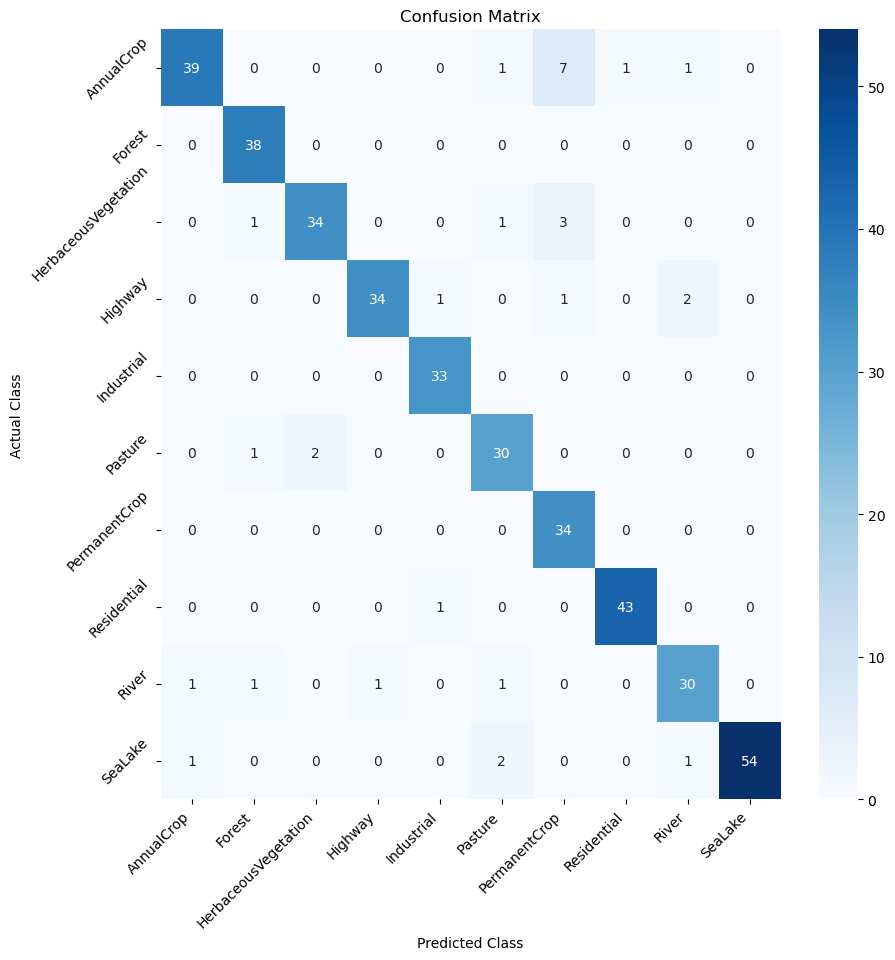

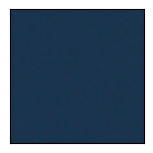

Predicted class: SeaLake
Actual class: SeaLake


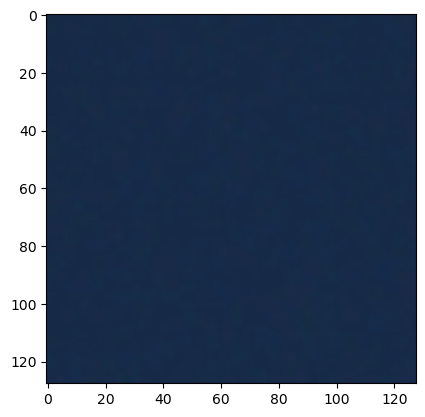

Predicted class: SeaLake
Actual class: SeaLake


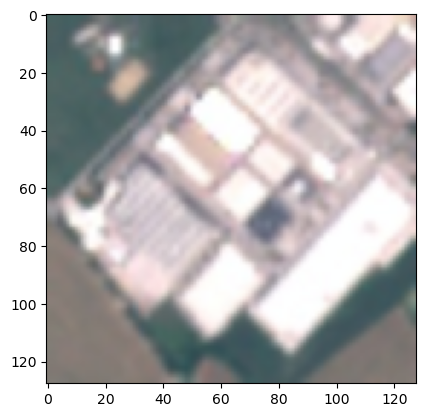

Predicted class: Industrial
Actual class: Industrial


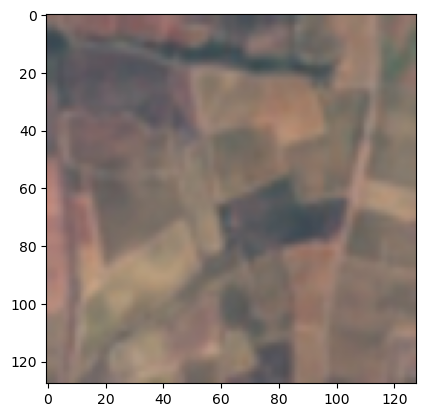

Predicted class: PermanentCrop
Actual class: PermanentCrop


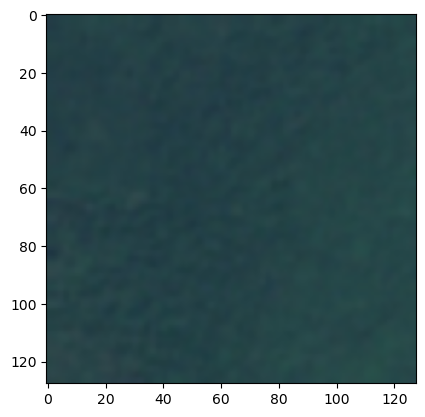

Predicted class: Forest
Actual class: Forest


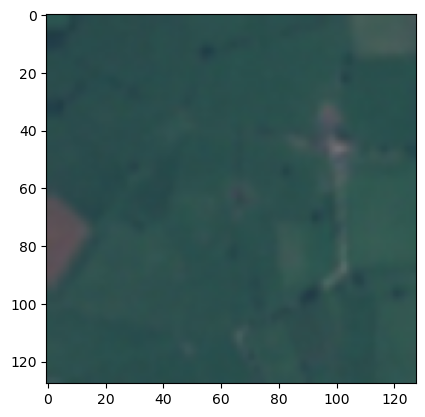

Predicted class: Pasture
Actual class: Pasture


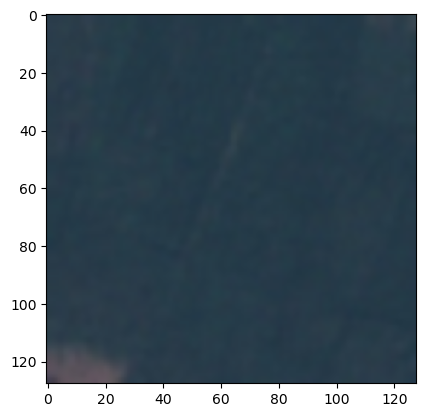

Predicted class: Forest
Actual class: Forest


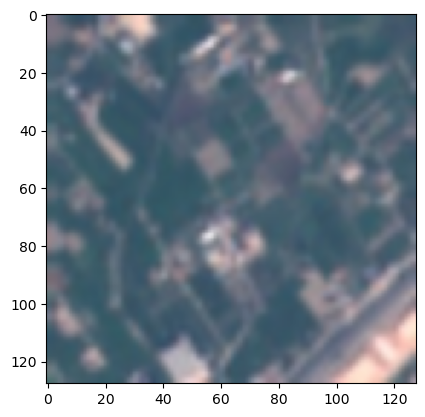

Predicted class: PermanentCrop
Actual class: PermanentCrop


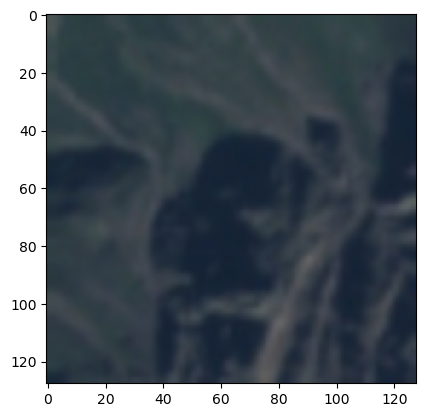

Predicted class: HerbaceousVegetation
Actual class: HerbaceousVegetation


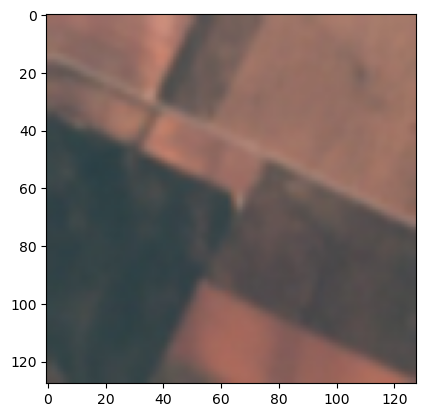

Predicted class: PermanentCrop
Actual class: AnnualCrop


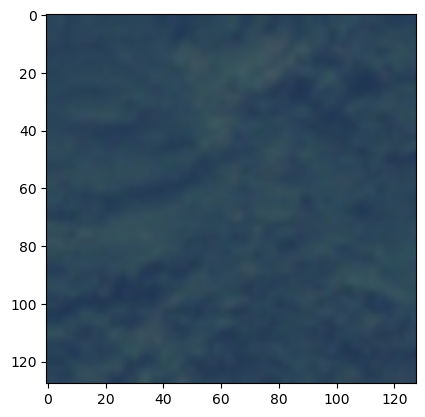

Predicted class: Forest
Actual class: Forest


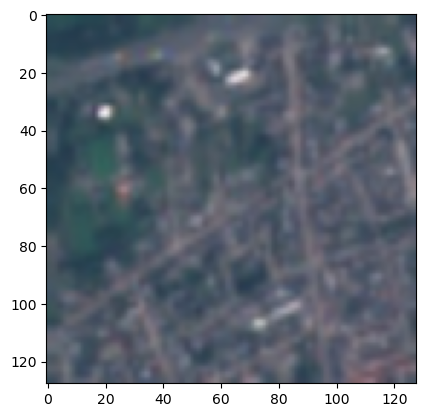

Predicted class: Residential
Actual class: Residential


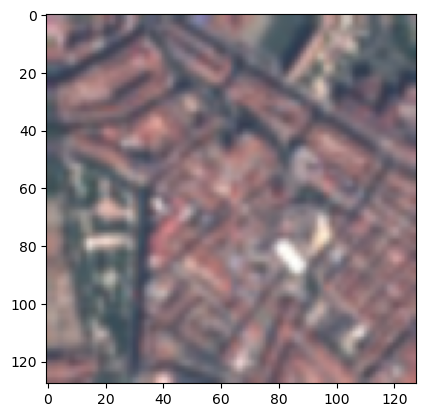

Predicted class: Residential
Actual class: Residential


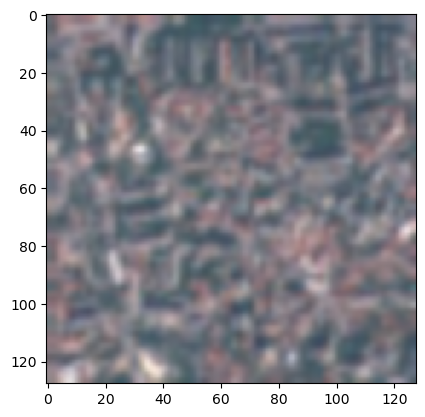

Predicted class: Residential
Actual class: Residential


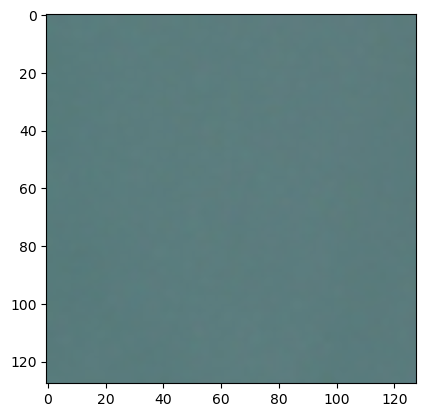

Predicted class: SeaLake
Actual class: SeaLake


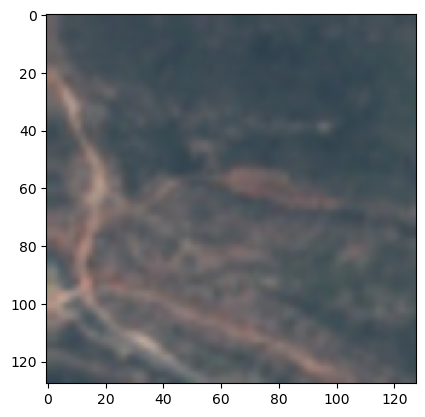

Predicted class: HerbaceousVegetation
Actual class: HerbaceousVegetation


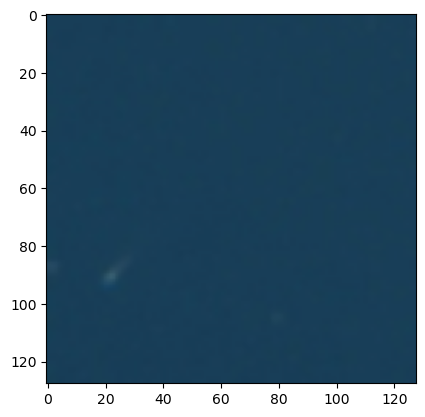

Predicted class: SeaLake
Actual class: SeaLake


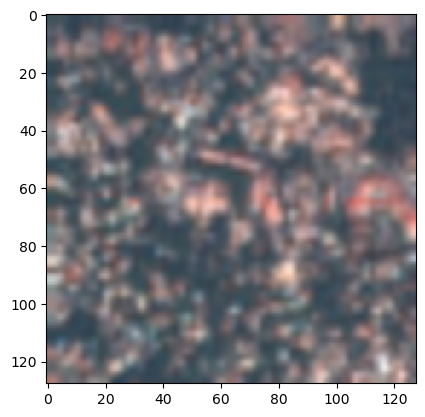

Predicted class: Residential
Actual class: Residential


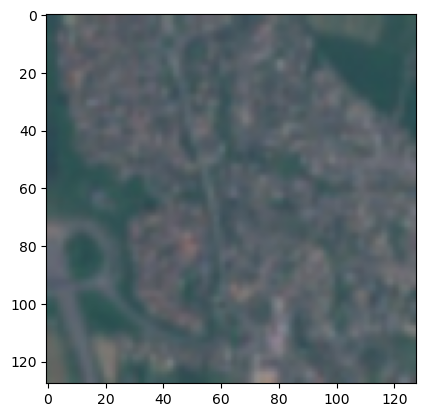

Predicted class: Residential
Actual class: Residential


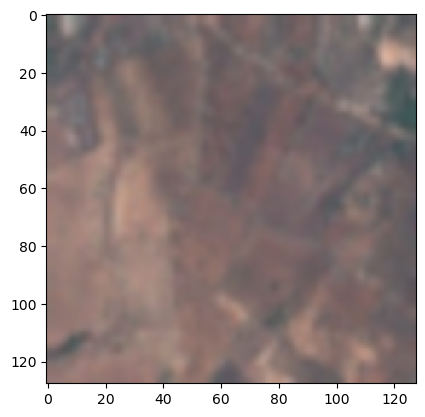

Predicted class: PermanentCrop
Actual class: PermanentCrop


In [37]:
#It takes roughly 3 minutes to run this script on a machine with 16GB of RAM.
#You can change the subset_size and num_epoch variables to slightly improve neural network accuracy at the expense of more processing time, or vice versa.
#However, improvements in accuracy are very small when making further adjustments. For example, I ran this with 10,000 pictures and 10 epochs,
#getting 93.4% accuracy. I then ran it with 2,000 pictures and 5 epochs, which took a fraction of the time and generated 92.2% accuracy.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load a subset of the dataset
full_dataset = datasets.ImageFolder(root='C:/Users/jason/Downloads/STA380-master/STA380-master/data/EuroSAT_RGB', transform=data_transforms)
subset_size = min(2000, len(full_dataset))  # Accuracy will improve slightly the more images you use here, but processing time goes up as well
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
subset_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Split dataset and create dataloaders
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define model 
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 11) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Accuracy will improve slightly the more epochs you use here, but processing time goes up as well
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}')

# Evaluation; get accuracy, precision, recall, f1 score
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

#valuate accuracy, precision, recall, f1 score
accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Overall Accuracy: {accuracy:.2f}%')

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
for i, class_name in enumerate(full_dataset.classes):
    print(f'{class_name}:')
    print(f'  Precision: {precision[i]:.2f}')
    print(f'  Recall: {recall[i]:.2f}')
    print(f'  F1-score: {f1[i]:.2f}')

# Confusion Matrix and visualizations
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
class_names = full_dataset.classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.setp(plt.gca().get_yticklabels(), rotation=45, ha='right')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get test data and make preictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8)) 
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    
    # Determine if the prediction was correct
    is_correct = preds[idx] == labels[idx].item()
    color = "green" if is_correct else "red"
    
    # Display the predicted and true class
    predicted_class = full_dataset.classes[preds[idx]]
    actual_class = full_dataset.classes[labels[idx]]
    
    print(f"Predicted class: {predicted_class}\nActual class: {actual_class}")

plt.show()